In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import geopandas as gpd
sys.path.append("../../../")
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv("../dataset/usa_o3.csv")

In [4]:
df.head()

,Latitude,Longitude,Sample Measurement
0,37.858932,-87.575291,0.040264
1,40.049604,-75.241209,0.046745
2,42.713897,-87.798634,0.045693
3,38.848232,-121.515236,0.046687
4,39.907891,-75.149066,0.038572


In [5]:
centroids = np.load("USA_Centroids.npy")

In [6]:
X = df[['Longitude', 'Latitude']].values
y = df[['Sample Measurement']].values * 1000

## Spatial Averaging

In [7]:
from polire.interpolate import SpatialAverage
spatial = SpatialAverage(coordinate_type='Geographic', radius=16.1)
spatial.fit(X, y)

SpatialAverage

In [8]:
spatial_predictions = np.zeros(centroids.shape[0])

for ix in np.arange(0, centroids.shape[0], 1000):
    
    if centroids.shape[0] - ix >= 1000: 
        spatial_predictions[ix: ix + 1000] = spatial.predict(centroids[ix:ix + 1000]).reshape(1000, )
    
    else: 
        spatial_predictions[ix: ] = spatial.predict(centroids[ix:])

## IDW

In [9]:
from polire.interpolate import Idw
from polire.utils.distance import haversine, euclidean
idw = Idw(coordinate_type='Geographic')
idw.fit(X, y)

Idw

In [10]:
idw_predictions = np.zeros(centroids.shape[0])
for ix, data_point in enumerate(centroids):
    distances = haversine(data_point, X)
    mask = distances <= 250
    X_train = X[mask]
    y_train = y[mask]
    idw_predictions[ix] = idw.predict(data_point.reshape(1, 2))

### $k$-NN, with $k = 1$.

In [11]:
from polire.custom import CustomInterpolator
from sklearn.neighbors import KNeighborsRegressor
knn = CustomInterpolator(KNeighborsRegressor, reg_kwargs={'n_neighbors':1})
knn.fit(X, y)
knn_predictions = knn.predict(centroids)

## Correlation Coefficients

In [12]:
from scipy.stats import pearsonr

* KNN, IDW
* KNN, Spatial Averaging
* IDW, Spatial Averaging

In [13]:
knn_predictions = knn_predictions.reshape(-1, )
idw_predictions = idw_predictions.reshape(-1, )
spatial_predictions = spatial_predictions.reshape(-1, )
mask = ~np.isnan(spatial_predictions)

In [14]:
pearsonr(knn_predictions[mask], spatial_predictions[mask])

(0.9517796076373709, 0.0)

In [15]:
pearsonr(idw_predictions, knn_predictions)

(0.9001251111133384, 0.0)

In [16]:
pearsonr(idw_predictions[mask], spatial_predictions[mask])

(0.9594420412754217, 0.0)

In [17]:
temp = []
for ix in range(knn_predictions.shape[0]):
    temp.append([
                    knn_predictions[ix], idw_predictions[ix], spatial_predictions[ix]
                ])

In [18]:
hist = []
for ix, _ in enumerate(temp):
    mask = ~np.isnan(temp[ix])
        
    if mask.sum() == 3:
        maximum_value = np.max(temp[ix])
        minimum_value = np.min(temp[ix])
        hist.append(maximum_value - minimum_value)

In [19]:
hist1 = []
for ix, _ in enumerate(temp):
    mask = ~np.isnan(temp[ix])
    if mask.sum() < 4:
        if mask.sum() >= 2:
            temp2 = np.array(temp[ix])[mask]
            maximum_value = np.max(temp2)
            minimum_value = np.min(temp2)
            hist1.append(maximum_value - minimum_value)
        
    if mask.sum() == 3:
        maximum_value = np.max(temp[ix])
        minimum_value = np.min(temp[ix])
        hist1.append(maximum_value - minimum_value)

In [20]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

In [21]:
from sklearn.neighbors import KernelDensity

In [22]:
max_hist = np.array(hist1).max() + 1
x_d = np.linspace(0, max_hist, 1000)

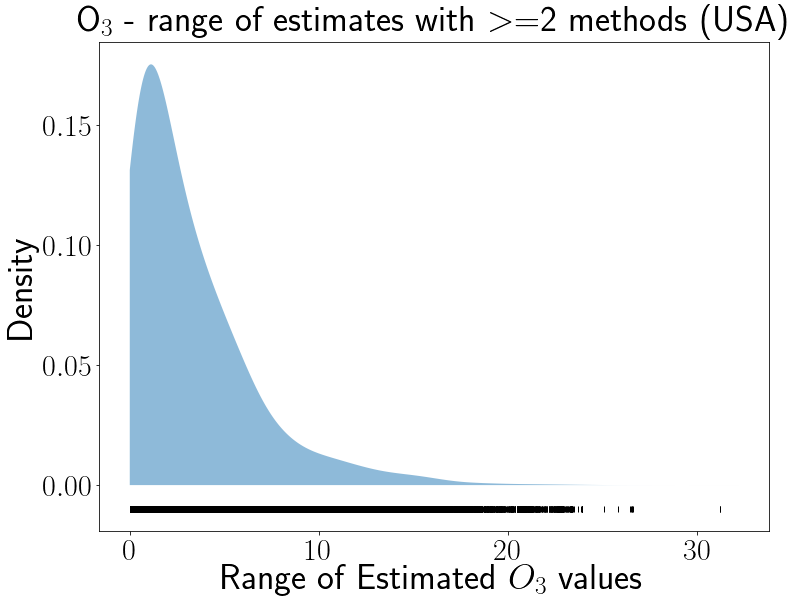

In [23]:
fig = plt.figure(figsize=(12, 9))

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.1, kernel='gaussian')
kde.fit(np.array(hist1)[:, None])
logprob = kde.score_samples(x_d[:, None])
plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(np.array(hist1), np.full_like(np.array(hist1), -0.01), '|k', markeredgewidth=1)

plt.title("O$_3$ - range of estimates with $>=$2 methods (USA)", fontsize=36)
plt.xlabel("Range of Estimated $O_3$ values", fontsize=36)
plt.ylabel("Density",fontsize = 36)
plt.tick_params(axis='both', labelsize=30)